In [1]:
%config InlineBackend.figure_format = 'retina' # For mac users with Retina display
import numpy as np
import matplotlib as mtlp
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import yaml
import pymc3 as pm
import arviz as az
import theano
import pandas as pd
from matplotlib import rc
from scipy import optimize
import seaborn as sns
import pickle 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patches as mpl_patches
######
import sys
sys.path.append('../HelpherFunctions/')
from Chi2Allvar import *
from mypygtc import * # modified version 
######
rc('text', usetex=True)
filename ="../results/data.yaml"
########
stream = open(filename, 'r')#
data = yaml.safe_load(stream)
#
colpastil = ['#9cadce','#937eba','#f09494','#72bbd0','#52b2cf','#ffafcc','#d3ab9e' ]
NBINS = 100
LambdaNP2 = 1e+3**2
v4 = 246.**4
v3 = 246.**3
mh2 = 125.1**2
sqrt_2 = np.sqrt(2.0)

In [2]:

def mode(x):
    """ Finds the mode of x
        argument:
            x: an array
    """
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def multimode(x, n, hdi_prob):
    """ Finds all the modes in the distribution
        arguments:
            x: the array for the distribution
            n: the identifier for the variable
    """
    md = az.hdi(x, hdi_prob=hdi_prob, multimodal=False)
    if len(md) < 2 and n > 1:
        return np.NaN
    else:
        return md[n%2]
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res
unity = lambda x : x
stats_func_2 = {
        'b0': lambda x: multimode(x, 0, 0.9545),
        'b1': lambda x: multimode(x, 1, 0.9545),
        }
stats_func_1 = {
        'b0': lambda x: multimode(x, 0, 0.6827),
        'b1': lambda x: multimode(x, 1, 0.6827),
        }

In [3]:
def runMCMC(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        k1 = pm.Uniform('k1', lower=limits[0], upper=limits[1])
        k2 = pm.Uniform('k2', lower=limits[2], upper=limits[3])
        k3 = pm.Uniform('k3', lower=limits[4], upper=limits[5])
        k4 = pm.Uniform('k4', lower=limits[6], upper=limits[7])

        like = pm.Potential('like', likelihood(k1, k2, k3, k4))
        
    if fit:
        with model:
       #     theano.config.compute_test_value = "off"
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) # Turn on to print summary
       #     theano.config.compute_test_value = "off"
           # if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
            with open(trace_dir, 'wb') as buff:
                pickle.dump({'model': model, 'trace': trace}, buff)
        return trace, model
    return model

 

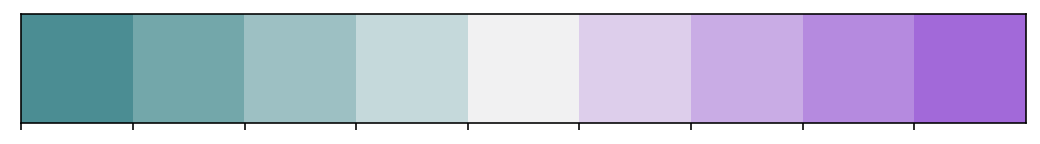

In [4]:
sns.palplot(sns.diverging_palette(200, 283, s=70, l=55, n=9))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 13500
Interrupted at 13,499 [6%]: Average Loss = 45.881
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [k4, k3, k2, k1]


Sampling 50 chains for 20_000 tune and 100_000 draw iterations (1_000_000 + 5_000_000 draws total) took 6119 seconds.
The number of effective samples is smaller than 25% for some parameters.


          0         1         2         3
0  1.000000  0.975697  0.488108 -0.329797
1  0.975697  1.000000  0.582590 -0.151291
2  0.488108  0.582590  1.000000  0.491455
3 -0.329797 -0.151291  0.491455  1.000000


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


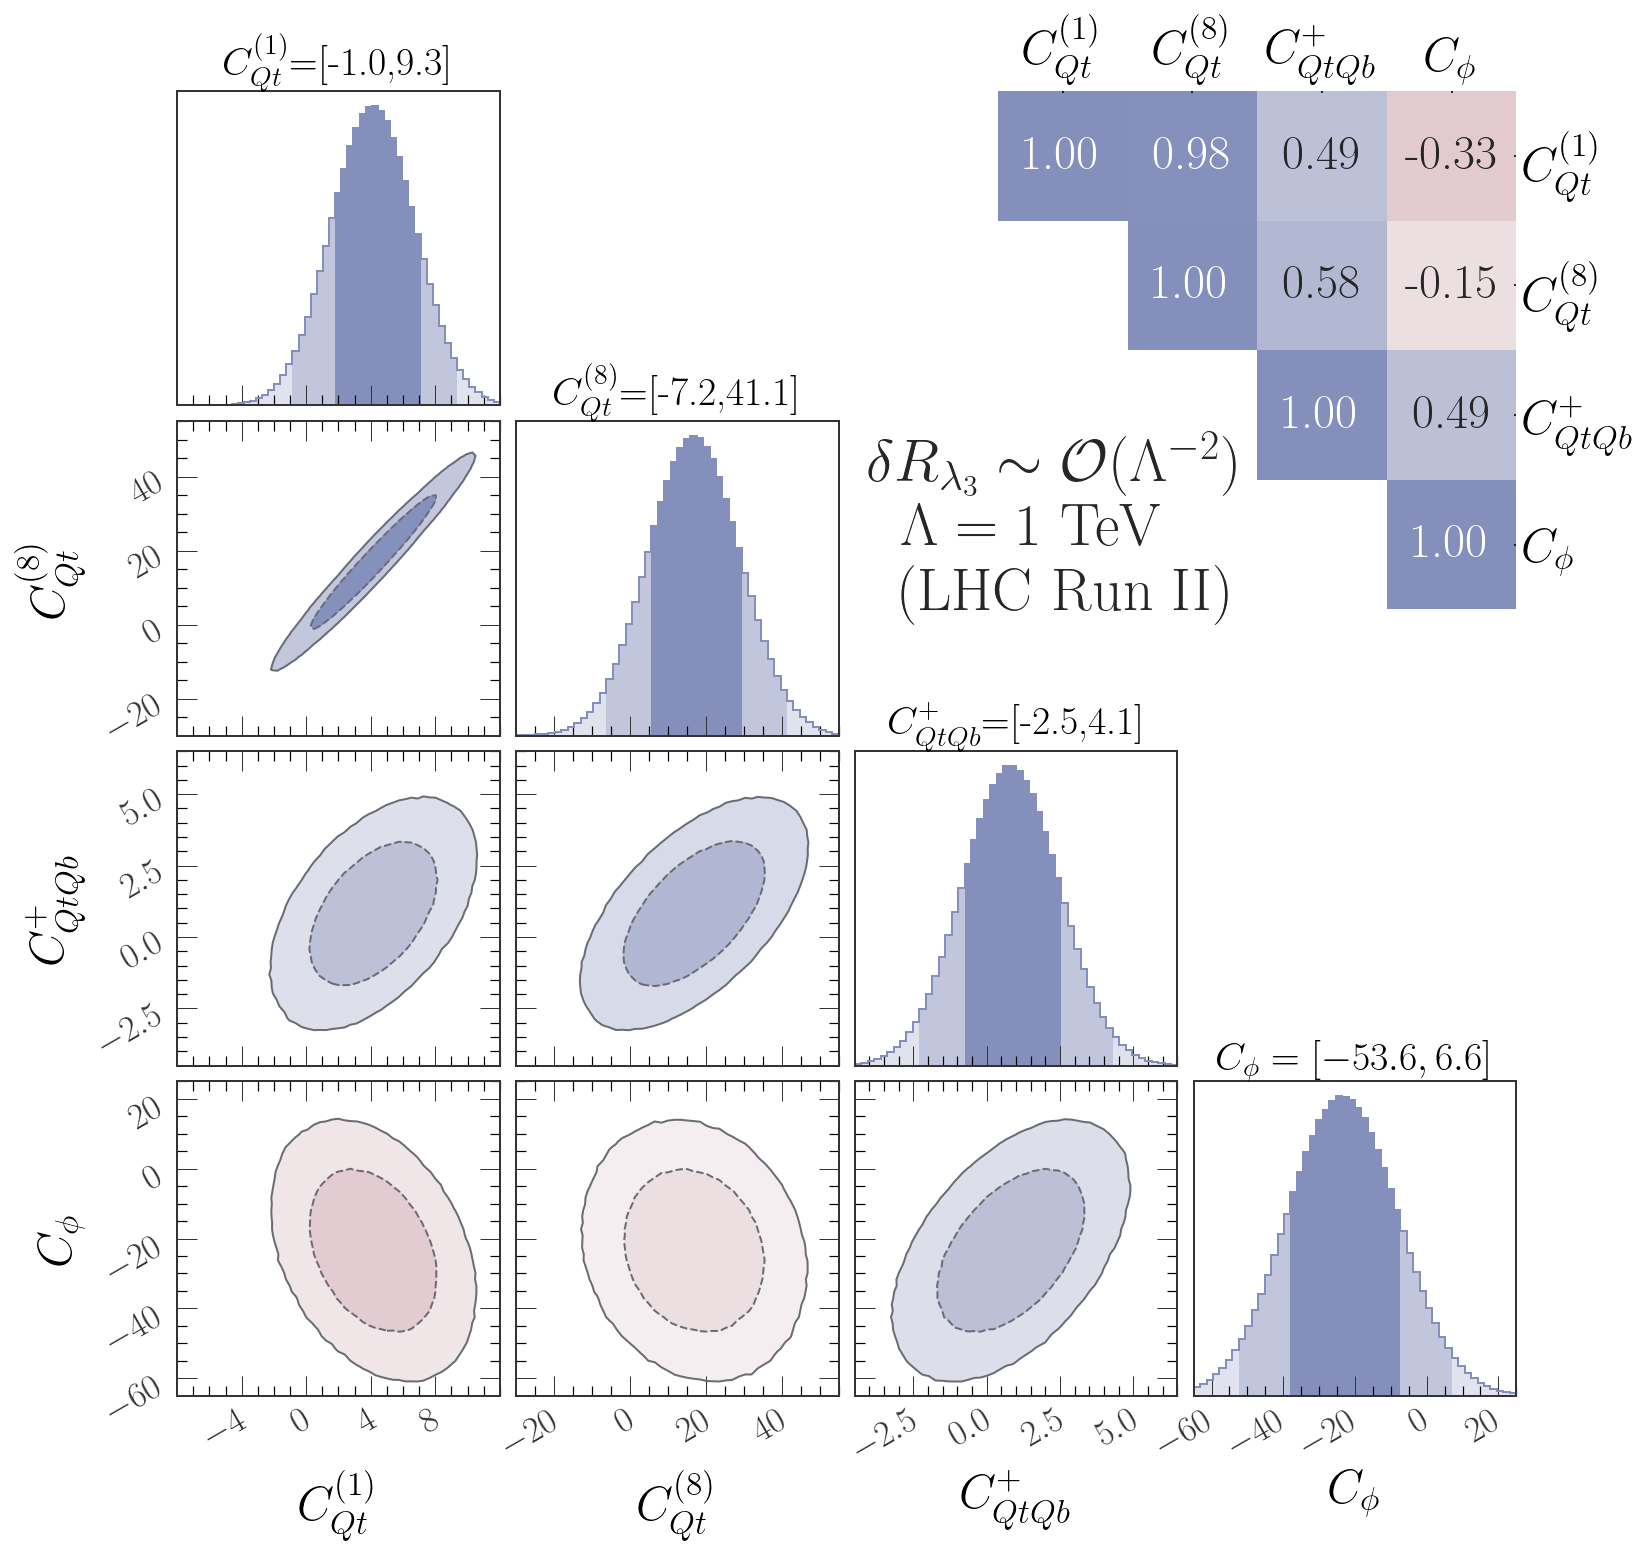

In [5]:
## 
NBINS = 50
CF=4/3
Nc=3
var=[r'$C_{Qt}^{(1)}$',r'$C_{Qt}^{(8)}$',r'$C_{QtQb}^{+}$',r'$C_\phi$']
col=['#9cadce','#cad0e4','#dbe0ee']
## ***************************************************************************
## * RC param                                                                 *
## ***************************************************************************
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['font.family'] = 'serf'
## ***************************************************************************
#col =['#7395ab','#aebdcb','#cdd7e2']
##
llCqtm =lambda Cqu1,Cqu8,Cquqbp,CH :mylikelihoodAV(Cqu1,Cqu8,
                                                   1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['CMS','ATLAS'],
                                                                         HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                   ,TopChannels=None,mode='rge', l3mode='linear',linearmu=True)

#
#llCqtm =lambda Cqu1,Cqu8,Cquqbp,CH :mylikelihoodAV(Cqu1,Cqu8,
 #                                                  1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['HL-LHC'],
  #                                                                       HiggsChannels=['ggf','vbf','wh','zh','ttxhhllhc'],mode='rge'
   #                                                                     ,TopChannels=None,l3mode='quadratic',linearmu=True) 
#limits = [-8., 12,-30.0,55.,-2.5,6.5, -25, 15] #for quad run2
limits = [-8., 12,-30.0,55.,-4.5,6.5, -65, 25] #for lin run2
#limits = [-4., 4.,-15.,15.,-4.,4., -30, 30]
config = [100000, 0.8, 50]
trace_dir='../results/fits/4paramfit_LHC_RunII_l3L_rge.pickle'
#trace_dir1='../results/fits/4paramfit.pickle'
trace_1, model_1 = runMCMC(llCqtm, limits, config=config,trace_dir=trace_dir)
with open(trace_dir, 'rb') as buff:
        data1 = pickle.load(buff)
        model = data1['model']
        trace_1 = data1['trace']
        
        
tr1 =np.array([trace_1.get_values('k1', burn=100, combine=True)]).flatten().T
tr2 =np.array([trace_1.get_values('k2', burn=100, combine=True)]).flatten().T
tr3 =np.array([trace_1.get_values('k3', burn=100, combine=True)]).flatten().T
tr4 =np.array([trace_1.get_values('k4', burn=100, combine=True)]).flatten().T
##

samples = np.array([tr1,tr2,tr3,tr4])
#plt.violinplot(tr4)
samples2 = np.vstack((tr1,tr2,tr3,tr4)).T
tr = pd.DataFrame(samples2)
corr=tr.corr()
print(corr)
paramRanges = ((limits[0], limits[1]),
               (limits[2], limits[3]),
               (limits[4], limits[5]),
              (limits[6], limits[7]))
pal= sns.diverging_palette(259,0,s=38,l=60, n=201,as_cmap=False)
#pal=sns.diverging_palette(200, 283, s=70, l=55, n=201)
GTC = plotGTC(chains=samples2,
                    paramNames=var,
                   # chainLabels=[r'$\lambda_3^{L}$',r'$\lambda_3^{R}$'],
                    paramRanges=paramRanges,
              #      truths=[0.],
               #     priors=xmu,
               #     truthLabels='',
                    smoothingKernel=0,
                    nBins=NBINS, #40525e
                    #  colorsOrder=['lina_blues'],
                    Bildgruess =(12,12),
                    holdRC=True,
                    palette=pal,
                    panelSpacing='loose',
                    mathTextFontSet=None,
                    customLegendFont={'family':'serf', 'size':28},
                    customTickFont={'family':'serf', 'size':18},
                    customLabelFont={'family':'serf', 'size':24},
                    #doOnly1dPlot=True,
                    plotDensity= False,
                    filledPlots=True)
axx = GTC.get_axes()

vl=['k1','k2','k3','k4']
df_1 = pd.DataFrame(az.summary(trace_1, kind='stats', hdi_prob=0.6827, round_to='none', stat_funcs=stats_func_1))
df_2 = pd.DataFrame(az.summary(trace_1, kind='stats', hdi_prob=0.9545, round_to='none', stat_funcs=stats_func_2))

for j in range(4):
    for i in range(NBINS):
        
            lim_1l = min((df_1.loc[vl[j]]['b0']),(df_1.loc[vl[j]]['b1']))
            lim_1u = max((df_1.loc[vl[j]]['b0']),(df_1.loc[vl[j]]['b1']))     
            lim_2l = min((df_2.loc[vl[j]]['b0']),(df_2.loc[vl[j]]['b1']))
            lim_2u = max((df_2.loc[vl[j]]['b0']),(df_2.loc[vl[j]]['b1'])) 
            if axx[6+j].patches[i].xy[0] > lim_1l and axx[6+j].patches[i].xy[0] < lim_1u:
                axx[6+j].patches[i].set_alpha(1.0)
            elif axx[6+j].patches[i].xy[0] > lim_2l and axx[6+j].patches[i].xy[0] < lim_2u:
                axx[6+j].patches[i].set_alpha(.5)
            else:
                axx[6+j].patches[i].set_alpha(.25)

#######                
for ax in GTC.get_axes():
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='both', direction='in')
        ax.tick_params(axis='x',  which='both',direction='in')
        ax.tick_params(axis='y', which='minor', top=True, size= 5)
        ax.tick_params(axis='x',  which='minor',right=True,size= 5)
        ax.tick_params(axis='y', which='major', rotation=30,top=True,size=10 )
        ax.tick_params(axis='x',  which='major', rotation=30,right=True,size=10 )

axx[9].set_title(r'$C_\phi=[{:3.1f},{:3.1f}]$'.format(df_2.loc['k4']['hdi_2.275%'],df_2.loc['k4']['hdi_97.725%']),fontsize=20)
axx[6].set_title(r'{}=[{:2.1f},{:2.1f}]'.format(r"$C_{Qt}^{(1)}$",df_2.loc['k1']['hdi_2.275%'],df_2.loc['k1']['hdi_97.725%']),fontsize=20)

axx[7].set_title(r'{}=[{:2.1f},{:2.1f}]'.format(r"$C_{Qt}^{(8)}$",df_2.loc['k2']['hdi_2.275%'],df_2.loc['k2']['hdi_97.725%']),fontsize=20)

axx[8].set_title(r'{}=[{:2.1f},{:2.1f}]'.format(r"$C_{QtQb}^+$",df_2.loc['k3']['hdi_2.275%'],df_2.loc['k3']['hdi_97.725%']),fontsize=20)
###################################################################
l, b, h, w = .6, .58, .3, .3
ax2 = GTC.add_axes([l, b, w, h])
#ax2.plot([1, 4, 6, 2, 1, 5, 2], color='green', lw=3, label="inside plot")
cmap = sns.diverging_palette(0,259,s=38,l=60, as_cmap=True)
#cmap=sns.diverging_palette(283,200 , s=70, l=55, n=201 ,as_cmap=True)
mask = np.zeros((corr.shape[1],corr.shape[1]))
mask[np.tril_indices_from(mask)] = True
np.fill_diagonal(mask,0)
heat = sns.heatmap(corr+0., mask=mask, center=0.00,cbar=False,annot=True, cmap=cmap, cbar_kws={"aspect": 50}, xticklabels=var, yticklabels=var,
                   annot_kws={"fontsize": 24},ax=ax2,fmt='.2f')
sns.set(font_scale=2., style='ticks')
ax2.text(-1.,3.0,r"$\delta R_{\lambda_3}\sim \mathcal{O}(\Lambda^{-2})$",fontsize=30)
ax2.text(-0.75,3.5,r"$\Lambda=1$ TeV",fontsize=30)
ax2.text(-0.75,4.,r"(LHC Run II)",fontsize=30)
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 24, rotation=0)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 24, rotation=0)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']}) 
heat.xaxis.tick_top() 
heat.xaxis.set_label_position('top')
heat.yaxis.tick_right() 
heat.yaxis.set_label_position('right')
heat.tick_params(axis='both', which='major', size=1)
GTC.savefig( '../results/plots/4param_fit_LHC_RunII_l3L_rge.pdf', dpi=300,transparent=False,bbox_inches='tight')
plt.show()

In [6]:
from iminuit import Minuit
import tabulate as tab
import seaborn as sns
from matplotlib.colors import LogNorm
def fit4(func):
    m = Minuit(func,Cqu1=0,Cqu8=0,Cquqbp=0,CH=0)
    m.errordef= Minuit.LEAST_SQUARES
    m.migrad()
    print(m.values)
    print(m.errors)
    print(m.params)
    print(tab.tabulate(*m.covariance.correlation().to_table()))
    #print(m.matrix(correlation=True))
    return m.covariance.correlation()

llCqtmchi2 =lambda Cqu1,Cqu8,Cquqbp,CH :-2*mylikelihoodAV(Cqu1,Cqu8,
                                                   1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=False,linearmu=True)

fit4linear = fit4(llCqtmchi2)


<ValueView Cqu1=-0.48013621696434056 Cqu8=-8.305885900744242 Cquqbp=1.8575322368183418 CH=-7.276265424492062>
<ErrorView Cqu1=0.8234413008469181 Cqu8=7.075070469771941 Cquqbp=1.4855683869787473 CH=9.583208628999243>
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Cqu1   │   -0.5    │    0.8    │            │            │         │         │       │
│ 1 │ Cqu8   │    -8     │     7     │            │            │         │         │       │
│ 2 │ Cquqbp │    1.9    │    1.5    │            │            │         │         │       │
│ 3 │ CH     │    -7     │    10     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
          Cqu1     Cqu8    Cquqbp       

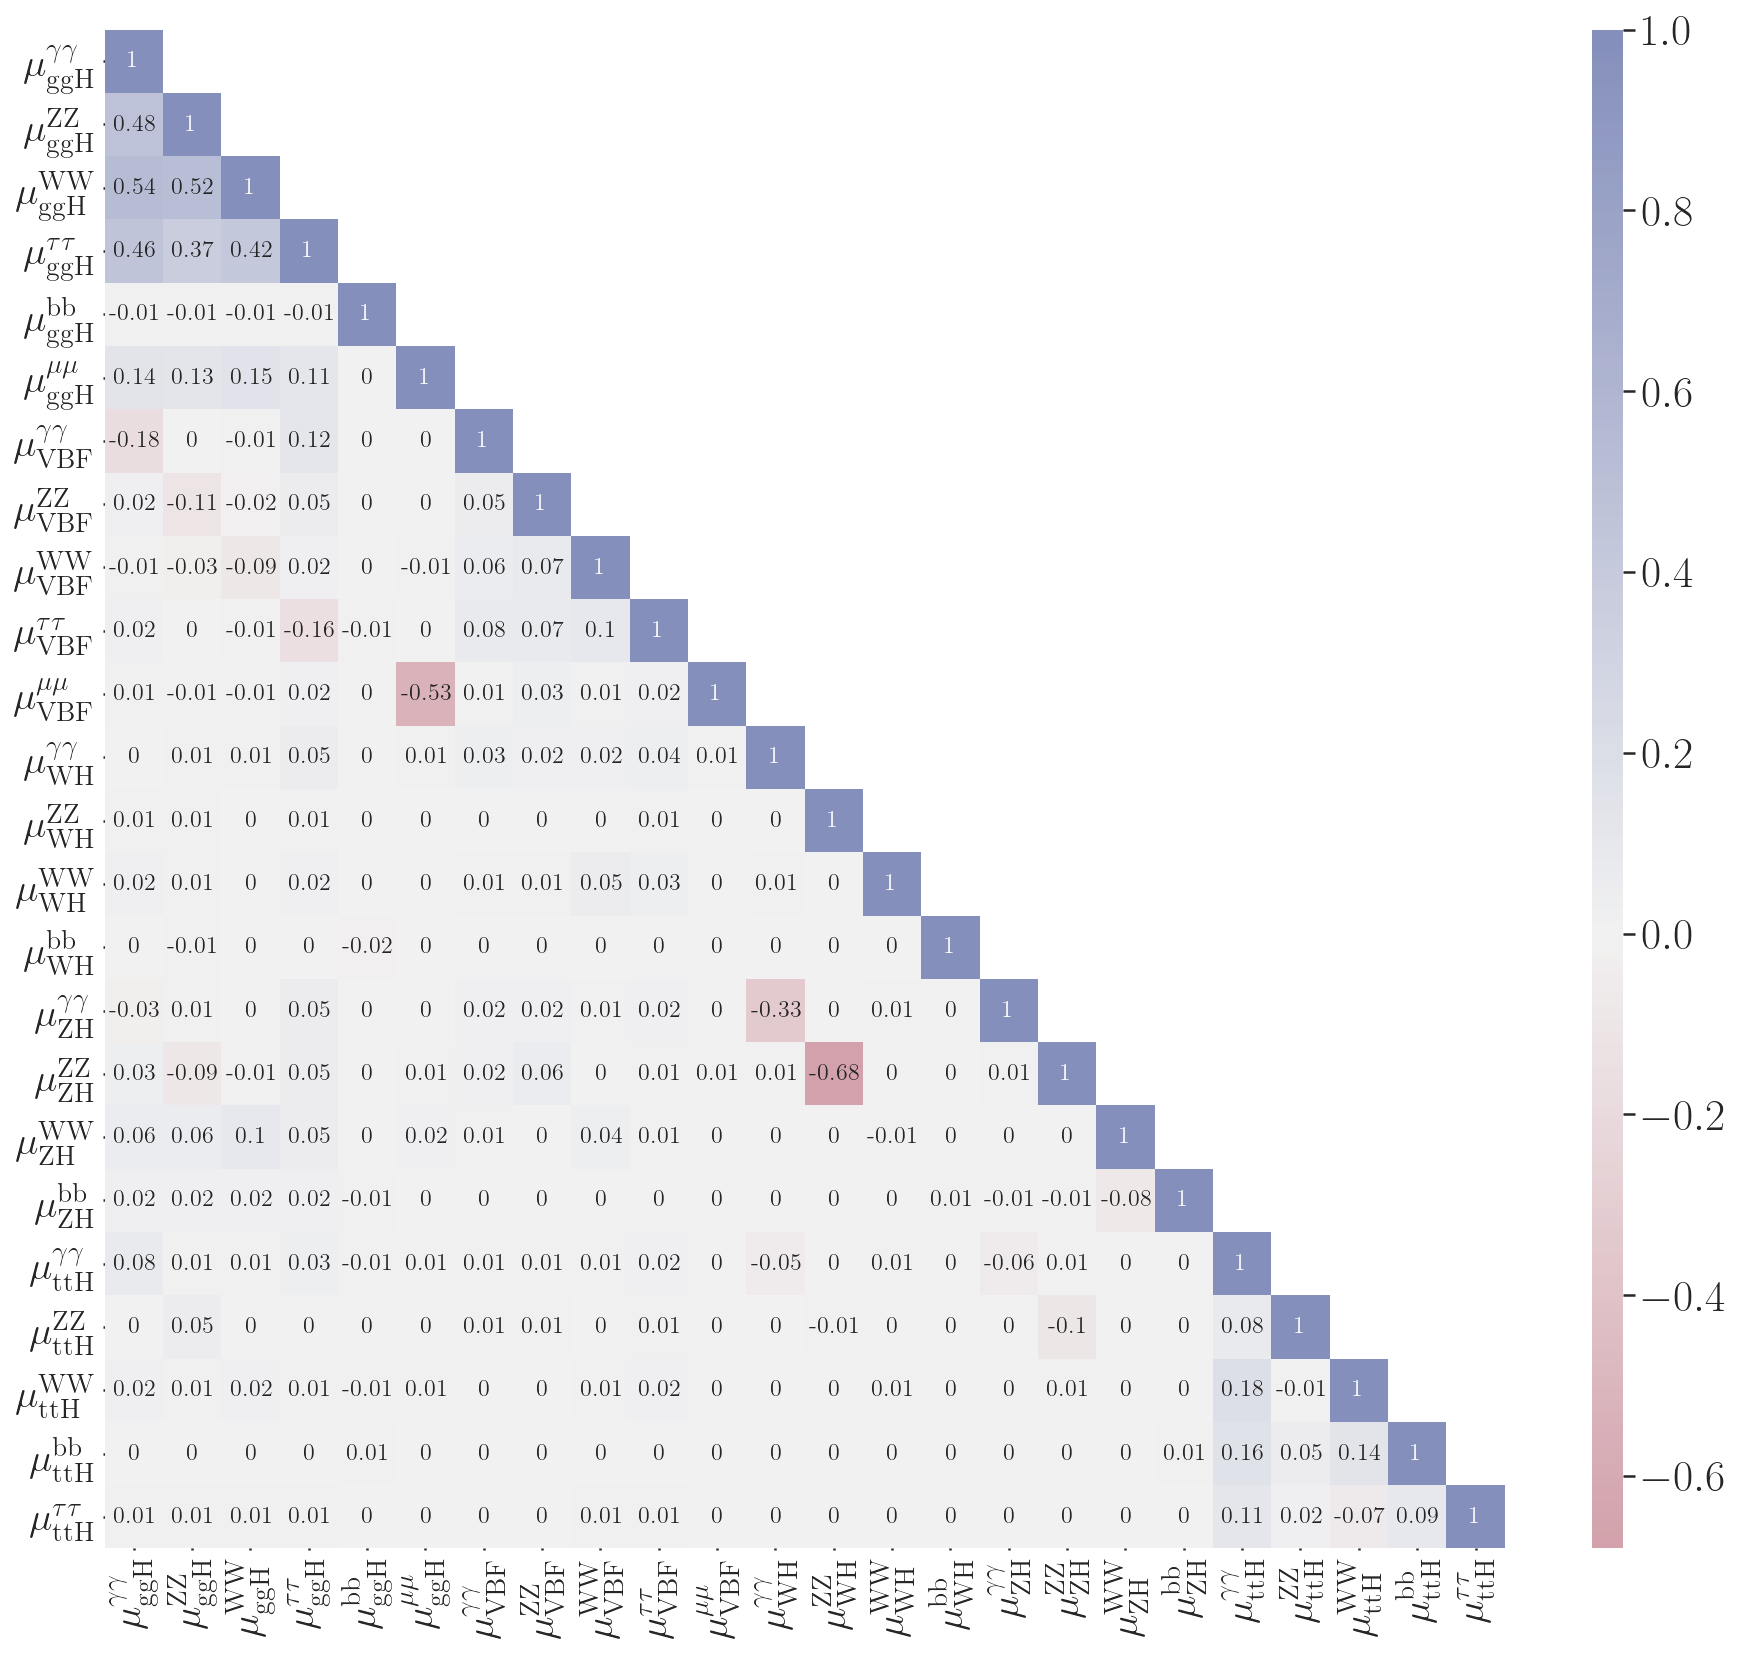

In [26]:
var=[r'$\mu_{\mathrm{ggH}}^{\gamma \gamma }$',
r'$\mu_{\mathrm{ggH}}^{\mathrm{ZZ}}$',
r'$\mu_{\mathrm{ggH}}^{\mathrm{WW}}$',
r'$\mu_{\mathrm{ggH}}^{\tau \tau }$',
r'$\mu_{\mathrm{ggH}}^{\mathrm{bb}}$',
r'$\mu_{\mathrm{ggH}}^{\mu \mu } $',
r'$\mu_{\mathrm{VBF}}^{\gamma \gamma }$',
r'$\mu_{\mathrm{VBF}}^{\mathrm{ZZ}}$',
r'$\mu_{\mathrm{VBF}}^{\mathrm{WW}}$',
r'$\mu_{\mathrm{VBF}}^{\tau \tau }$',
r'$\mu_{\mathrm{VBF}}^{\mu \mu } $',
r'$\mu_{\mathrm{WH}}^{\gamma \gamma }$',
r'$\mu_{\mathrm{WH}}^{\mathrm{ZZ}}$',
r'$\mu_{\mathrm{WH}}^{\mathrm{WW}}$',
r'$\mu_{\mathrm{WH}}^{\mathrm{bb}}$',
r'$\mu_{\mathrm{ZH}}^{\gamma \gamma }$',
r'$\mu_{\mathrm{ZH}}^{\mathrm{ZZ}}$',
r'$\mu_{\mathrm{ZH}}^{\mathrm{WW}}$',
r'$\mu_{\mathrm{ZH}}^{\mathrm{bb}}$',
r'$\mu_{\mathrm{ttH}}^{\gamma \gamma }$',
r'$\mu_{\mathrm{ttH}}^{\mathrm{ZZ}}$',
r'$\mu_{\mathrm{ttH}}^{\mathrm{WW}}$',
r'$\mu_{\mathrm{ttH}}^{\mathrm{bb}}$',
r'$\mu_{\mathrm{ttH}}^{\tau \tau }$']

dirc= '/beegfs/desy/user/lalasfar/trilinear4tops'
corr =crr2=np.loadtxt(dirc+"/results/correlation_matrix_CMS_HL-LHC.dat")
fig, ax = plt.subplots(figsize=(13.5, 12))
cmap = sns.diverging_palette(0,259,s=38,l=60, as_cmap=True)
mask = np.zeros((corr.shape[1],corr.shape[1]))
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask,0)
heat = sns.heatmap(corr+0., mask=mask, center=0.0,cbar=True,annot=True, cmap=cmap, cbar_kws={"aspect": 50}, xticklabels=var, yticklabels=var,
                   annot_kws={"fontsize": 12})
ax = plt.gca()
sns.set(font_scale=2., style='ticks')
#plt.text(2.4,1.1,r"(Higgs data)",fontsize=26)
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 20, rotation=90)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 20, rotation=0)
#heat.set_xticks([])
heat.set_xticks([], minor=True)
#heat.set_yticks([])
heat.set_yticks([], minor=True)
heat.tick_params(axis='both', which='major', size=1)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']}) 
plt.tight_layout()
fig.savefig('../results/plots/4param_corr_l3r.pdf', dpi=300)

<ValueView Cqup=-11.865653278637163 Cqum=10.869027751078487 Cquqbp=1.8924874260672686 CH=-7.3963776776588>
<ErrorView Cqup=20.304937526073818 Cqum=17.52043484311348 Cquqbp=2.9766122063308624 CH=19.086511284179895>
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Cqup   │    -12    │    20     │            │            │         │         │       │
│ 1 │ Cqum   │    11     │    17     │            │            │         │         │       │
│ 2 │ Cquqbp │    1.9    │    3.0    │            │            │         │         │       │
│ 3 │ CH     │    -7     │    19     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
            Cqup     Cqum    Cquqbp       

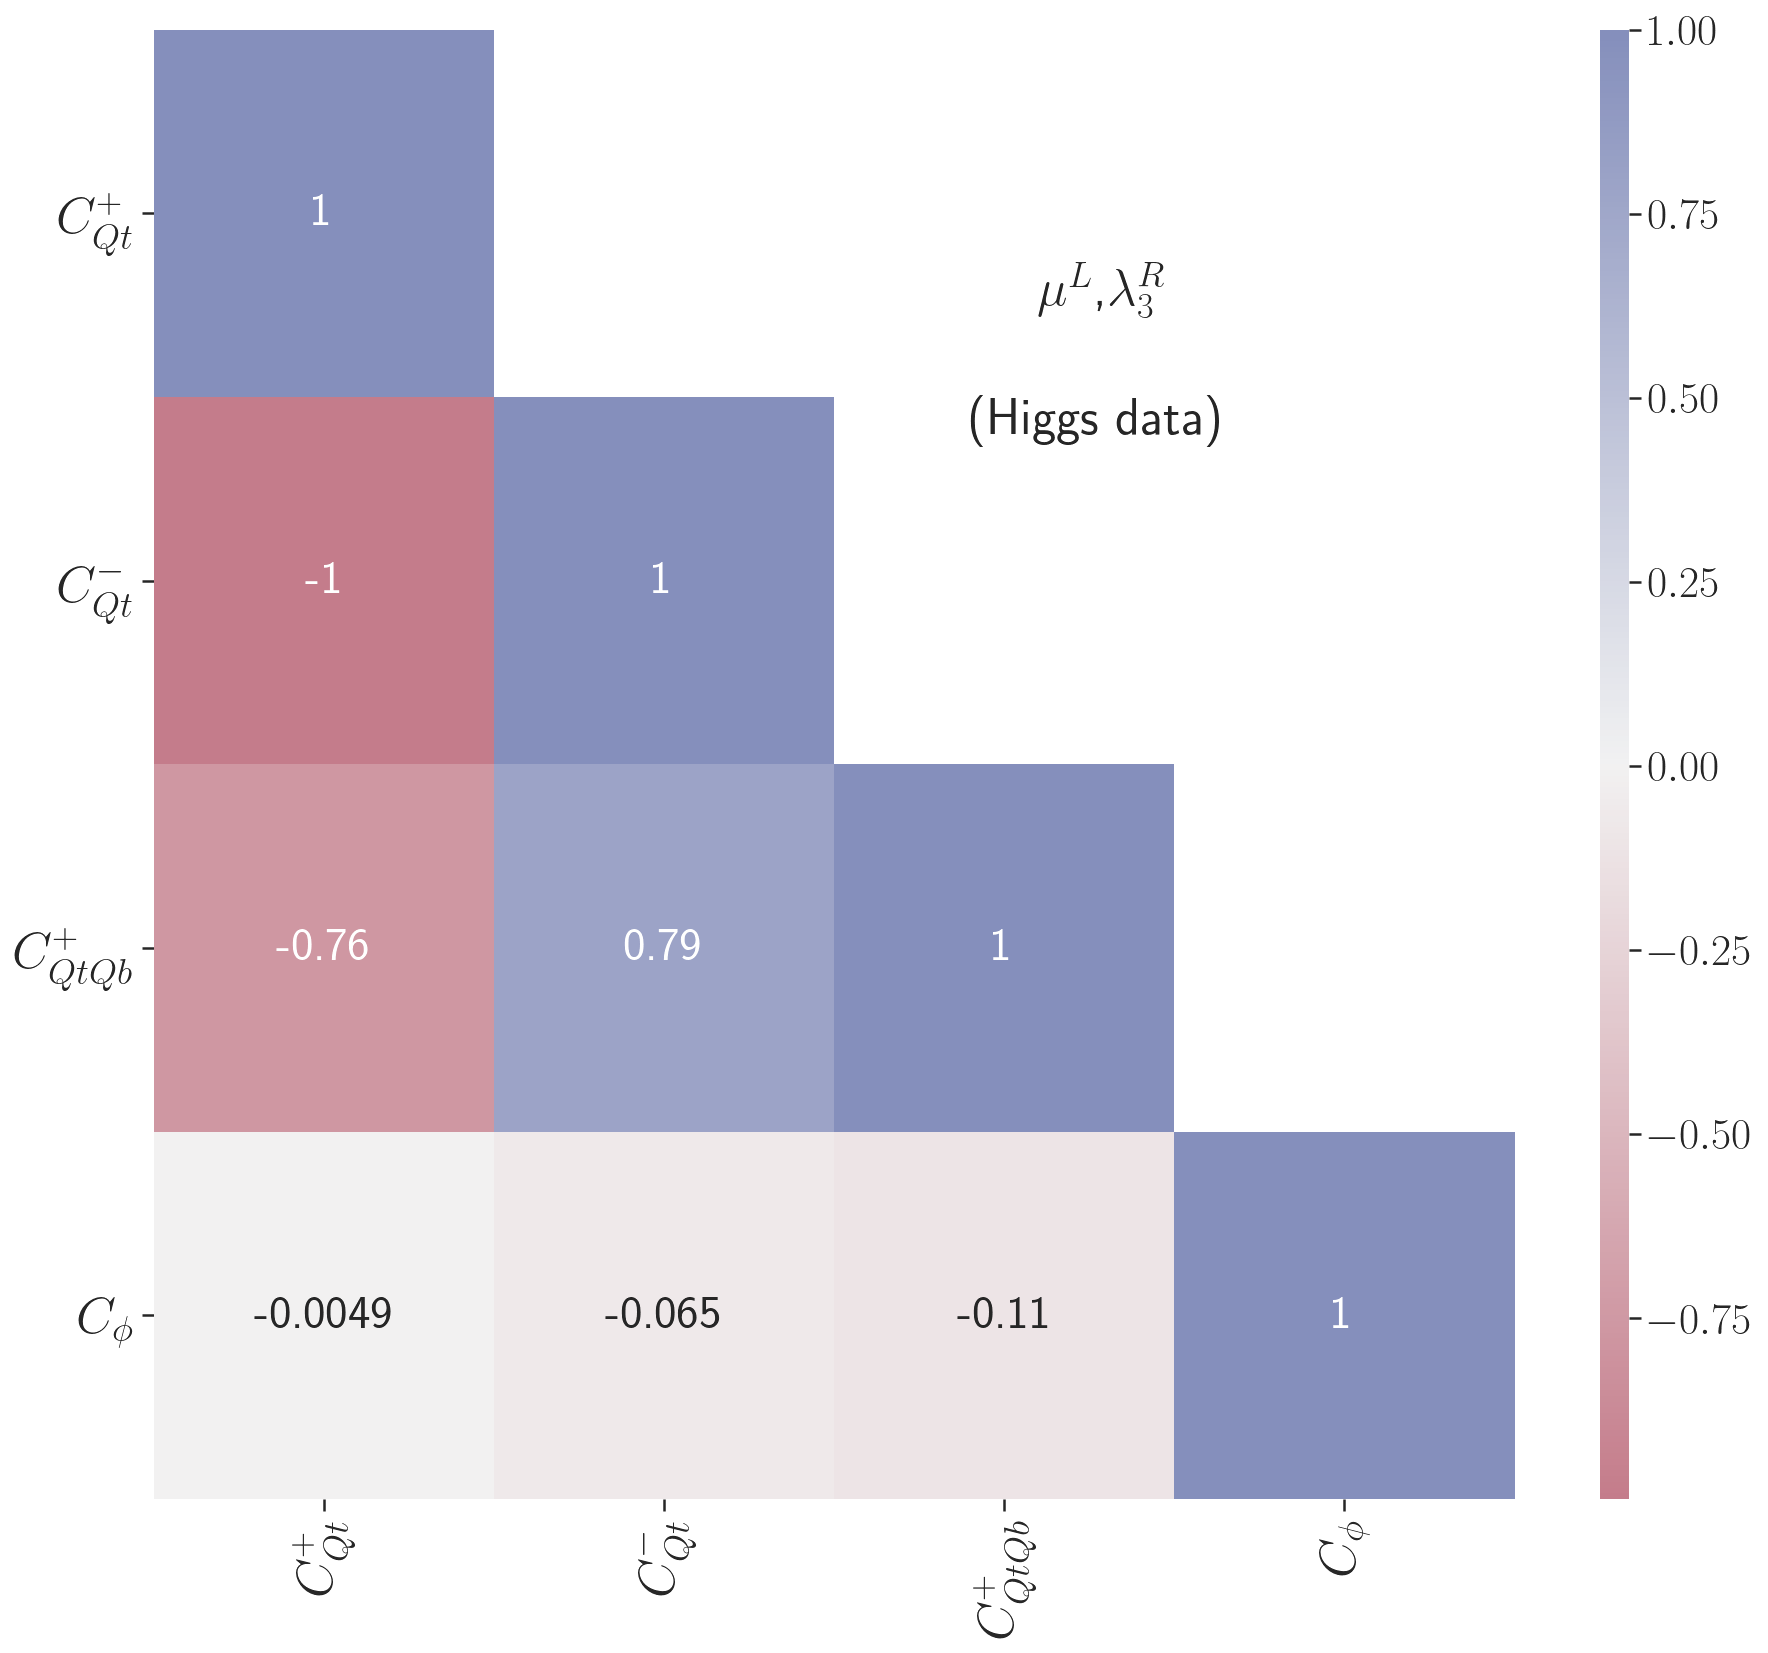

In [23]:
llCqtmchi2 =lambda Cqup,Cqum,Cquqbp,CH :-1/2*mylikelihoodAV(1/2*(Cqup+Cqum),1/2/CF*(Cqup-Cqum),
                                                   1/2/(2*Nc+1)*Cquqbp,+1/CF*Cquqbp/2,CH,data,experiments=['CMS','ATLAS'],
                                                                           HiggsChannels=['ggf','vbf','ttxh','vh','zh','wh']
                                                                           ,TopChannels=None, linearl3=False,linearmu=True)

fit4linear = fit4(llCqtmchi2)
fig, ax = plt.subplots(figsize=(13.5, 12))
cmap = sns.diverging_palette(0,259,s=38,l=60, as_cmap=True)
mask = np.zeros((fit4linear.shape[1],fit4linear.shape[1]))
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask,0)
heat = sns.heatmap(fit4linear+0., mask=mask, annot=True, cmap=cmap, cbar_kws={"aspect": 50}, xticklabels=var, yticklabels=var,
                   annot_kws={"fontsize": 24})
ax = plt.gca()
sns.set(font_scale=2., style='ticks')
plt.text(2.6,.75,r"$\mu^L$,$\lambda_3^R$",fontsize=26)
plt.text(2.4,1.1,r"(Higgs data)",fontsize=26)
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 26, rotation=90)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 26, rotation=0)
plt.tight_layout()
fig.savefig('../results/plots/4param_corr_l3_R.pdf', dpi=300)